#Pre Processamento

In [ ]:
# ======================================
# 1) Imports e carregamento do dataset
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import genpareto

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Caminho do dataset
DATASET_PATH = "Dataset_com_Anomalias.csv"

# Carrega o dataset
df = pd.read_csv(DATASET_PATH)

print("Primeiras linhas do dataset:")
display(df.head())

print("\nInformações gerais:")
print(df.info())


Primeiras linhas do dataset:


,datetime,"PRECIPITACAO TOTAL, HORARIO(mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, DIRECAO HORARIA (gr)(° (gr))","VENTO, RAJADA MAXIMA(m/s)","VENTO, VELOCIDADE HORARIA(m/s)",anomalia
0,2010-01-01 00:00:00,0.0,943.1,-3.4,21.9,80.0,145.0,7.0,3.5,False
1,2010-01-01 01:00:00,0.0,943.8,-3.5,21.5,82.0,172.0,5.1,1.2,False
2,2010-01-01 02:00:00,0.0,944.0,-3.2,21.4,83.0,163.0,3.7,2.7,False
3,2010-01-01 03:00:00,0.0,943.5,-3.4,21.3,83.0,162.0,4.6,3.6,False
4,2010-01-01 04:00:00,0.0,943.0,-3.5,20.9,86.0,157.0,4.9,2.9,False



Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112544 entries, 0 to 112543
Data columns (total 10 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   datetime                                              112544 non-null  object 
 1   PRECIPITACAO TOTAL, HORARIO(mm)                       112544 non-null  float64
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)  112544 non-null  float64
 3   RADIACAO GLOBAL(Kj/m²)                                112544 non-null  float64
 4   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)           112544 non-null  float64
 5   UMIDADE RELATIVA DO AR, HORARIA(%)                    112544 non-null  float64
 6   VENTO, DIRECAO HORARIA (gr)(° (gr))                   112544 non-null  float64
 7   VENTO, RAJADA MAXIMA(m/s)                             112544 non-null  float64
 8   VENTO, VELOCIDADE HORAR

In [ ]:
# ======================================
# 2) Selecionando Features e verificando dados ausentes
# ======================================
selected_features = [
    "PRECIPITACAO TOTAL, HORARIO(mm)",
    "RADIACAO GLOBAL(Kj/m²)",
    "UMIDADE RELATIVA DO AR, HORARIA(%)"
]
label_column = "anomalia"

df_selected = df[selected_features + [label_column]].copy()

# Verificando quantos nulos existem em cada coluna
print("Contagem de nulos:\n", df_selected.isnull().sum())

print("\nExemplo de dados:")
display(df_selected.head(10))



Contagem de nulos:
 PRECIPITACAO TOTAL, HORARIO(mm)       0
RADIACAO GLOBAL(Kj/m²)                0
UMIDADE RELATIVA DO AR, HORARIA(%)    0
anomalia                              0
dtype: int64

Exemplo de dados:


,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"UMIDADE RELATIVA DO AR, HORARIA(%)",anomalia
0,0.0,-3.4,80.0,False
1,0.0,-3.5,82.0,False
2,0.0,-3.2,83.0,False
3,0.0,-3.4,83.0,False
4,0.0,-3.5,86.0,False
5,0.0,-2.6,89.0,False
6,0.0,-2.3,88.0,False
7,0.0,-1.2,87.0,False
8,0.0,-2.2,91.0,False
9,0.0,21.7,91.0,False


In [ ]:
# ======================================
# 4) Normalização / Escalonamento
# ======================================
from sklearn.preprocessing import StandardScaler

df_selected["RADIACAO GLOBAL(Kj/m²)"] = df_selected["RADIACAO GLOBAL(Kj/m²)"].clip(lower=0)

scaler = StandardScaler()
# Ajusta apenas nas colunas de interesse (não no label)
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])

print("Estatísticas após normalizar:")
display(df_selected[selected_features].describe())


Estatísticas após normalizar:


,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"UMIDADE RELATIVA DO AR, HORARIA(%)"
count,1.125440e+05,1.125440e+05,1.125440e+05
mean,-1.313201e-17,-2.131426e-16,-3.394119e-16
std,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.187493e-01,-7.394238e-01,-3.339987e+00
25%,-1.187493e-01,-7.394238e-01,-6.856731e-01
50%,-1.187493e-01,-6.772064e-01,2.893811e-01
75%,-1.187493e-01,6.777287e-01,8.310779e-01
max,4.763190e+01,3.225927e+00,1.426944e+00


In [ ]:
# ======================================
# 5) Montar janelas e gerar (X, y)
# ======================================
def criar_janelas(dataframe, features, label_col, window_size=48):
    X, y = [], []
    df_values = dataframe[features].values  # shape=(N,3) depois da normalização
    label_values = dataframe[label_col].values.astype(int)

    for i in range(len(df_values) - window_size):
        janela = df_values[i : i + window_size]  # (72,3)
        # Se qualquer linha da janela tiver label=1 => y=1
        y_janela = 1 if label_values[i : i + window_size].any() else 0

        X.append(janela)
        y.append(y_janela)

    return np.array(X), np.array(y)

window_size = 48
X, y = criar_janelas(df_selected, selected_features, label_column, window_size)

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Distribuição y:", np.unique(y, return_counts=True))


Shape X: (112496, 48, 3)
Shape y: (112496,)
Distribuição y: (array([0, 1]), array([81975, 30521]))


In [ ]:
# ======================================
# 6) Split Treino / Val
# ======================================
test_ratio = 0.2
split_point = int(len(X)*(1 - test_ratio))

X_train, X_val = X[:split_point], X[split_point:]
y_train, y_val = y[:split_point], y[split_point:]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape,   "y_val:",   y_val.shape)


X_train: (89996, 48, 3) y_train: (89996,)
X_val: (22500, 48, 3) y_val: (22500,)


#Declaracao e treinamento de modelos

##OminAnomaly VAE

In [ ]:
###############################################################################
# OmniAnomaly Revisado com Seleção Dinâmica do Percentil para POT + Dropout
# (BiLSTM no Encoder, 2 camadas LSTM no Decoder, Parâmetros Unificados)
###############################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import genpareto

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

###############################################################################
# 1) Parâmetros Unificados em 'model_config'
###############################################################################
model_config = {
    "input_shape": (48, 3),     # (timesteps, features)
    "latent_dim": 8,          # Dimensão do espaço latente
    "n_flows": 5,             # Número de PlanarFlows
    "beta": 0.005,              # Fator KL
    "lr": 1e-3,                # Learning Rate
    "epochs": 100,
    "batch_size": 128,
    "earlystop_patience": 10,
    "reduceLR_patience": 5,

    # Parâmetros das LSTMs
    "enc_lstm_units": 64,       # Tamanho do BiLSTM no encoder
    "dec_lstm_units": [64, 32], # 2 camadas LSTM no decoder

    # Dropout adicional em cada LSTM (encoder e decoder)
    "dropout_rate": 0.1,

    # Faixa de candidatos para percentil inicial do POT
    "percentile_candidates": np.arange(0.80, 0.98, 0.005),
    "p_extreme": 1e-3
}

print("Parâmetros de modelo definidos em model_config:")
for k, v in model_config.items():
    print(f"  {k}: {v}")

###############################################################################
# 2) Classes PlanarFlow e OmniLossLayer
###############################################################################
class PlanarFlow(kl.Layer):
    """
    z -> z + u * tanh(w^T z + b). Aumenta expressividade da posterior.
    """
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim

    def build(self, input_shape):
        self.u = self.add_weight(
            shape=(self.latent_dim, 1),
            initializer='random_normal',
            trainable=True,
            name='pf_u'
        )
        self.w = self.add_weight(
            shape=(self.latent_dim, 1),
            initializer='random_normal',
            trainable=True,
            name='pf_w'
        )
        self.b = self.add_weight(
            shape=(1,),
            initializer='zeros',
            trainable=True,
            name='pf_b'
        )
        super().build(input_shape)

    def call(self, z):
        w_T_z = K.dot(z, self.w)  # (batch,1)
        return z + tf.transpose(self.u) * tf.tanh(w_T_z + self.b)

class OmniLossLayer(kl.Layer):
    """
    Recebe [x_in, x_rec, z_mean, z_log_var] e soma Recon + beta*KL na loss.
    """
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        x_in, x_rec, z_mean, z_log_var = inputs

        # Reconstrução (MSE)
        recon_err = tf.reduce_mean((x_in - x_rec)**2, axis=[1,2])
        recon_loss = tf.reduce_mean(recon_err)

        # KL
        kl_each = -0.5 * tf.reduce_sum(
            (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1
        )
        kl_loss = tf.reduce_mean(kl_each)

        # Soma final
        total_loss = recon_loss + self.beta * kl_loss
        self.add_loss(total_loss)
        return x_rec

###############################################################################
# 3) Função build_omnianomaly_vae -> 2 LSTMs no DECODER + Dropout
###############################################################################
def build_omnianomaly_vae(config):
    """
    Constrói OmniAnomaly:
      - input_shape e dims do config
      - BiLSTM no encoder com dropout
      - 2 LSTM no decoder (dec_lstm_units) com dropout
      - n_flows = config['n_flows']
      - OmniLossLayer
    """
    input_shape = config["input_shape"]
    latent_dim = config["latent_dim"]
    n_flows = config["n_flows"]
    beta = config["beta"]
    lr = config["lr"]

    enc_units = config["enc_lstm_units"]
    dec_units_list = config["dec_lstm_units"]
    dropout_rate = config.get("dropout_rate", 0.0)

    # ===== ENCODER (BiLSTM) =====
    x_in = Input(shape=input_shape, name="vae_input")
    # Camada Bidirecional LSTM com dropout
    bi_lstm_out = kl.Bidirectional(
        kl.LSTM(enc_units, return_sequences=False, activation='tanh',
                dropout=dropout_rate),
        name="bidirectional_encoder"
    )(x_in)  # => (batch, enc_units*2)

    # Camadas densas para z_mean, z_log_var
    z_mean = kl.Dense(latent_dim, name="z_mean")(bi_lstm_out)
    z_log_var = kl.Dense(latent_dim, name="z_log_var")(bi_lstm_out)

    # Sampling
    def sampling(args):
        zm, zv = args
        eps = K.random_normal(shape=(K.shape(zm)[0], latent_dim))
        return zm + tf.exp(0.5 * zv) * eps

    z0 = kl.Lambda(sampling, name="z0")([z_mean, z_log_var])

    # Planar Flows
    z_flow = z0
    for i in range(n_flows):
        z_flow = PlanarFlow(latent_dim, name=f"planar_flow_{i}")(z_flow)

    # ===== DECODER (2 camadas LSTM) =====
    z_in = Input(shape=(latent_dim,), name="z_in_decoder")
    repeated = kl.RepeatVector(input_shape[0])(z_in)

    # 1ª LSTM com dropout
    dec_lstm_out = kl.LSTM(dec_units_list[0], return_sequences=True, activation='tanh',
                           dropout=dropout_rate, name="decoder_lstm_1")(repeated)
    # 2ª LSTM com dropout
    dec_lstm_out2 = kl.LSTM(dec_units_list[1], return_sequences=True, activation='tanh',
                            dropout=dropout_rate, name="decoder_lstm_2")(dec_lstm_out)

    # Projeção final TimeDistributed
    x_rec = kl.TimeDistributed(
        kl.Dense(input_shape[1], activation='linear'),
        name="reconstruction"
    )(dec_lstm_out2)

    decoder_submodel = Model(z_in, x_rec, name="decoder_submodel")
    x_rec_out = decoder_submodel(z_flow)

    # LOSS
    x_out = OmniLossLayer(beta=beta)([x_in, x_rec_out, z_mean, z_log_var])
    vae_model = Model(x_in, x_out, name="OmniAnomalyVAE")
    vae_model.compile(optimizer=Adam(lr))

    # Submodelo extrator z_flow
    z_flow_extractor = Model(x_in, z_flow, name="z_flow_extractor")

    return vae_model, decoder_submodel, z_flow_extractor

###############################################################################
# 4) Função train_and_evaluate_vae
#    Seleção Dinâmica do Percentil via busca em 'percentile_candidates'
###############################################################################
def train_and_evaluate_vae(X_train, X_val, y_train, y_val, config):
    """
    Constrói/treina VAE c/ BiLSTM no encoder (com dropout),
    2 LSTMs no decoder (com dropout), e PlanarFlow.
    Faz threshold via POT, mas ajusta dinamicamente o percentil inicial
    pesquisando nas 'percentile_candidates' em config.
    """
    vae_model, dec_model, z_flow_ext = build_omnianomaly_vae(config)
    vae_model.summary()

    # Callbacks
    es = EarlyStopping(
        monitor="val_loss",
        patience=config["earlystop_patience"],
        restore_best_weights=True,
        verbose=1
    )
    rlrop = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=config["reduceLR_patience"],
        min_lr=1e-6,
        verbose=1
    )

    history = vae_model.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[es, rlrop],
        verbose=1
    )

    # Reconstrução val
    recon_val = vae_model.predict(X_val)
    recon_err_val = np.mean((X_val - recon_val)**2, axis=(1,2))

    # Fazemos pequena busca para escolher percentil inicial
    percentile_candidates = config.get("percentile_candidates", [0.9])
    p_extreme = config.get("p_extreme", 1e-2)

    best_f1 = -1
    best_th = None

    for q0 in percentile_candidates:
        # 1) Percentil inicial
        th_init = np.quantile(recon_err_val, q0)
        excesses = recon_err_val[recon_err_val > th_init] - th_init

        if len(excesses) > 0:
            shape_, loc_, scale_ = genpareto.fit(excesses, floc=0)
            th_candidate = th_init + genpareto.ppf(p_extreme, shape_, loc=loc_, scale=scale_)
        else:
            th_candidate = th_init

        # Avaliar F1
        y_pred_val_tmp = (recon_err_val > th_candidate).astype(int)
        prec_tmp = precision_score(y_val, y_pred_val_tmp)
        rec_tmp = recall_score(y_val, y_pred_val_tmp)
        f1_tmp = f1_score(y_val, y_pred_val_tmp)

        if f1_tmp > best_f1:
            best_f1 = f1_tmp
            best_th = th_candidate

    # Usa best_th final
    print(f"[INFO] Melhor percentil inicial e threshold => F1={best_f1:.4f}, threshold={best_th:.6f}")

    # Pred final
    y_pred_val = (recon_err_val > best_th).astype(int)
    prec = precision_score(y_val, y_pred_val)
    rec = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)

    print(f"[Val] Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    cm = confusion_matrix(y_val, y_pred_val)
    print("Matriz de Confusão:\\n", cm)

    # Plot
    plt.figure()
    plt.hist(recon_err_val, bins=50, alpha=0.5, label="Erros Recon (val)")
    plt.axvline(best_th, color='r', linestyle='--', label="Threshold")
    plt.title("Distribuição do Erro de Reconstrução")
    plt.xlabel("Erro")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()

    return vae_model, dec_model, z_flow_ext, history


Parâmetros de modelo definidos em model_config:
  input_shape: (48, 3)
  latent_dim: 8
  n_flows: 5
  beta: 0.005
  lr: 0.001
  epochs: 100
  batch_size: 128
  earlystop_patience: 10
  reduceLR_patience: 5
  enc_lstm_units: 64
  dec_lstm_units: [64, 32]
  dropout_rate: 0.1
  percentile_candidates: [0.8   0.805 0.81  0.815 0.82  0.825 0.83  0.835 0.84  0.845 0.85  0.855
 0.86  0.865 0.87  0.875 0.88  0.885 0.89  0.895 0.9   0.905 0.91  0.915
 0.92  0.925 0.93  0.935 0.94  0.945 0.95  0.955 0.96  0.965 0.97  0.975]
  p_extreme: 0.001


Model: "OmniAnomalyVAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape         ┃       Param # ┃ Connected to          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ vae_input (InputLayer)   │ (None, 48, 3)        │             0 │ -                     │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ bidirectional_encoder    │ (None, 128)          │        34,816 │ vae_input[0][0]       │
│ (Bidirectional)          │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ z_mean (Dense)           │ (None, 8)            │         1,032 │ bidirectional_encode… │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ z_log_var (Dense)        │ (None, 8)            │         1,032 │ bidirectional_encode… │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ z0 (Lambda)              │ (None, 8)            │             0 │ z_mean[0][0],         │
│                          │                      │               │ z_log_var[0][0]       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ planar_flow_0            │ (None, 8)            │            17 │ z0[0][0]              │
│ (PlanarFlow)             │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ planar_flow_1            │ (None, 8)            │            17 │ planar_flow_0[0][0]   │
│ (PlanarFlow)             │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ planar_flow_2            │ (None, 8)            │            17 │ planar_flow_1[0][0]   │
│ (PlanarFlow)             │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ planar_flow_3            │ (None, 8)            │            17 │ planar_flow_2[0][0]   │
│ (PlanarFlow)             │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ planar_flow_4            │ (None, 8)            │            17 │ planar_flow_3[0][0]   │
│ (PlanarFlow)             │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ decoder_submodel         │ (None, 48, 3)        │        31,203 │ planar_flow_4[0][0]   │
│ (Functional)             │                      │               │                       │
├──────────────────────────┼──────────────────────┼───────────────┼───────────────────────┤
│ omni_loss_layer_1        │ (None, 48, 3)        │             0 │ vae_input[0][0],      │
│ (OmniLossLayer)          │                      │               │ decoder_submodel[0][… │
│                          │                      │               │ z_mean[0][0],         │
│                          │                      │               │ z_log_var[0][0]       │
└──────────────────────────┴──────────────────────┴───────────────┴───────────────────────┘

 Total params: 68,168 (266.28 KB)

 Trainable params: 68,168 (266.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - loss: 0.7731 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - loss: 0.4743 - val_loss: 0.5309 - learning_rate: 0.0010
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - loss: 0.4427 - val_loss: 0.5002 - learning_rate: 0.0010
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - loss: 0.4299 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - loss: 0.4180 - val_loss: 0.4710 - learning_rate: 0.0010
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - loss: 0.4113 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - loss: 0.4095 - val_loss: 0.4527 - learning_rate: 0.0010
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - loss: 0.3991 - val_loss: 0.4251 - learning_rate: 0.0010
Epoch 9/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - loss: 0.3912 - val_loss: 0.4521 - learn

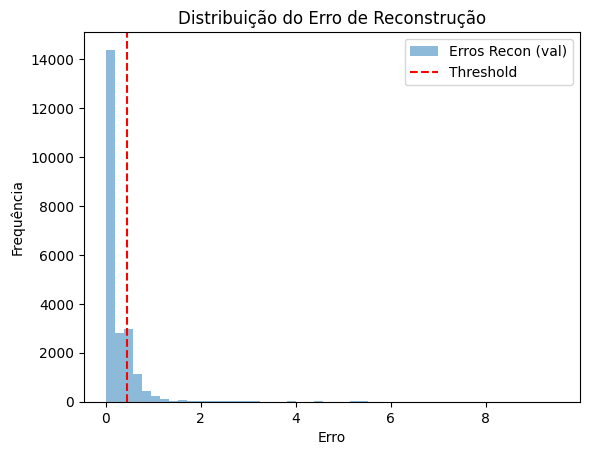

In [ ]:
vae_model, dec_model, z_flow, hist = train_and_evaluate_vae(
    X_train, X_val, y_train, y_val,
    model_config
)

In [ ]:
vae_model.save("vae_model.keras")

## LSTM-AE

In [ ]:
###############################################################################
# LSTM Autoencoder (Simples) com POT dinâmico para Threshold
# (2 camadas LSTM no Encoder e Decoder, sem sampling ou Flow)
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import genpareto

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

###############################################################################
# 1) Parâmetros Unificados em 'lstm_ae_config'
###############################################################################
lstm_ae_config = {
    "input_shape": (48, 3),       # (timesteps, features)
    "enc_units": [64, 32],        # 2 camadas LSTM no Encoder
    "dec_units": [32, 64],        # 2 camadas LSTM no Decoder (inverso)
    "dropout_rate": 0.2,          # Dropout opcional
    "lr": 1e-3,                   # Learning Rate
    "epochs": 50,
    "batch_size": 64,
    "earlystop_patience": 10,
    "reduceLR_patience": 5,

    # Parâmetros de Thresholding via POT
    "percentile_candidates": np.arange(0.80, 0.96, 0.01),
    "p_extreme": 1e-3
}

print("Parâmetros de modelo LSTM-AE em `lstm_ae_config`:")
for k, v in lstm_ae_config.items():
    print(f"  {k}: {v}")

###############################################################################
# 2) Função build_lstm_autoencoder
###############################################################################
def build_lstm_autoencoder(config):
    """
    Constrói um Autoencoder LSTM simples:
      - Encoder: 2 camadas LSTM
      - Decoder: 2 camadas LSTM (inverso)
      - Reconstrução MSE
    """
    input_shape = config["input_shape"]
    enc_units = config["enc_units"]
    dec_units = config["dec_units"]
    dropout_rate = config.get("dropout_rate", 0.0)
    lr = config["lr"]

    # ENCODER
    x_in = Input(shape=input_shape, name="ae_input")
    # 1ª LSTM (return_sequences=True)
    enc_out_1 = kl.LSTM(enc_units[0],
                        return_sequences=True,
                        dropout=dropout_rate,
                        activation='tanh',
                        name="encoder_lstm_1")(x_in)
    # 2ª LSTM (return_sequences=False) -> vetor latente
    enc_out_2 = kl.LSTM(enc_units[1],
                        return_sequences=False,
                        dropout=dropout_rate,
                        activation='tanh',
                        name="encoder_lstm_2")(enc_out_1)

    # DECODER
    # Precisamos de RepeatVector(timesteps) para replicar o vetor latente
    repeated = kl.RepeatVector(input_shape[0])(enc_out_2)

    # 1ª LSTM do decoder (espelhando)
    dec_out_1 = kl.LSTM(dec_units[0],
                        return_sequences=True,
                        dropout=dropout_rate,
                        activation='tanh',
                        name="decoder_lstm_1")(repeated)
    # 2ª LSTM do decoder (return_sequences=True p/ TimeDistributed)
    dec_out_2 = kl.LSTM(dec_units[1],
                        return_sequences=True,
                        dropout=dropout_rate,
                        activation='tanh',
                        name="decoder_lstm_2")(dec_out_1)

    # Saída final com TimeDistributed Dense (reconstruindo input_shape[1])
    x_rec = kl.TimeDistributed(
        kl.Dense(input_shape[1], activation='linear'),
        name="reconstruction"
    )(dec_out_2)

    ae_model = Model(x_in, x_rec, name="LSTM_AE")
    ae_model.compile(optimizer=Adam(lr), loss="mse")
    return ae_model

###############################################################################
# 3) Função de Treino e Avaliação via POT dinâmico
###############################################################################
def train_and_evaluate_lstm_ae(X_train, X_val, y_train, y_val, config):
    """
    Treina o LSTM-AE para reconstrução e aplica Threshold via POT no erro de
    reconstrução (MSE) para detectar anomalias.
    """
    ae_model = build_lstm_autoencoder(config)
    ae_model.summary()

    # Callbacks
    es = EarlyStopping(
        monitor="val_loss",
        patience=config["earlystop_patience"],
        restore_best_weights=True,
        verbose=1
    )
    rlrop = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=config["reduceLR_patience"],
        min_lr=1e-6,
        verbose=1
    )

    history = ae_model.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[es, rlrop],
        verbose=1
    )

    # Reconstrução no conjunto de validação
    recon_val = ae_model.predict(X_val)  # (nval, timesteps, features)
    # Erro de reconstrução por amostra
    recon_err_val = np.mean((X_val - recon_val)**2, axis=(1,2))

    # Seleção de threshold via POT (percorrendo candidates)
    percentile_candidates = config.get("percentile_candidates", [0.9])
    p_extreme = config.get("p_extreme", 1e-2)

    best_f1 = -1
    best_th = None

    for q0 in percentile_candidates:
        th_init = np.quantile(recon_err_val, q0)
        excesses = recon_err_val[recon_err_val > th_init] - th_init

        if len(excesses) > 0:
            shape_, loc_, scale_ = genpareto.fit(excesses, floc=0)
            th_candidate = th_init + genpareto.ppf(p_extreme, shape_, loc=loc_, scale=scale_)
        else:
            th_candidate = th_init

        y_pred_tmp = (recon_err_val > th_candidate).astype(int)
        prec_tmp = precision_score(y_val, y_pred_tmp)
        rec_tmp = recall_score(y_val, y_pred_tmp)
        f1_tmp = f1_score(y_val, y_pred_tmp)

        if f1_tmp > best_f1:
            best_f1 = f1_tmp
            best_th = th_candidate

    print(f"[INFO] Melhor threshold => F1={best_f1:.4f}, threshold={best_th:.6f}")

    # Predição final
    y_pred_val = (recon_err_val > best_th).astype(int)
    prec = precision_score(y_val, y_pred_val)
    rec = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)

    print(f"[Val] Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    cm = confusion_matrix(y_val, y_pred_val)
    print("Matriz de Confusão:\\n", cm)

    plt.figure()
    plt.hist(recon_err_val, bins=50, alpha=0.5, label="Erros Recon (val)")
    plt.axvline(best_th, color='r', linestyle='--', label="Threshold")
    plt.title("Distribuição do Erro de Reconstrução - LSTM-AE")
    plt.xlabel("Erro")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()

    return ae_model, history, (recon_err_val, best_th)


In [ ]:
# ======================================
# 5) Execução Final: Treinar e Avaliar LSTM Autoencoder
# ======================================
ae_lstm_model, ae_lstm_history, (recon_err_val, best_th) = train_and_evaluate_lstm_ae(
    X_train, X_val, y_train, y_val,
    lstm_ae_config
)


##GRU AE

In [ ]:
###############################################################################
# GRU Autoencoder (Simples) com POT dinâmico para Threshold
# (2 camadas GRU no Encoder e Decoder, sem sampling ou Flow)
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import genpareto

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

###############################################################################
# 1) Parâmetros Unificados em 'gru_ae_config'
###############################################################################
gru_ae_config = {
    "input_shape": (48, 3),      # (timesteps, features)
    "enc_units": [64, 32],       # 2 camadas GRU no Encoder
    "dec_units": [32, 64],       # 2 camadas GRU no Decoder (inverso)
    "dropout_rate": 0.2,         # Dropout opcional
    "lr": 1e-3,                  # Learning Rate
    "epochs": 80,
    "batch_size": 64,
    "earlystop_patience": 10,
    "reduceLR_patience": 5,

    # Parâmetros de Thresholding via POT
    "percentile_candidates": np.arange(0.80, 0.96, 0.01),
    "p_extreme": 1e-3
}

print("Parâmetros de modelo GRU-AE em `gru_ae_config`:")
for k, v in gru_ae_config.items():
    print(f"  {k}: {v}")

###############################################################################
# 2) Função build_gru_autoencoder
###############################################################################
def build_gru_autoencoder(config):
    """
    Constrói um Autoencoder GRU simples:
      - Encoder: 2 camadas GRU
      - Decoder: 2 camadas GRU (inverso)
      - Reconstrução via MSE
    """
    input_shape = config["input_shape"]
    enc_units = config["enc_units"]  # ex.: [64, 32]
    dec_units = config["dec_units"]  # ex.: [32, 64]
    dropout_rate = config.get("dropout_rate", 0.0)
    lr = config["lr"]

    # ENCODER
    x_in = Input(shape=input_shape, name="gru_ae_input")

    # 1ª GRU (return_sequences=True)
    enc_out_1 = kl.GRU(enc_units[0],
                       return_sequences=True,
                       dropout=dropout_rate,
                       activation='tanh',
                       name="encoder_gru_1")(x_in)

    # 2ª GRU (return_sequences=False) -> vetor latente
    enc_out_2 = kl.GRU(enc_units[1],
                       return_sequences=False,
                       dropout=dropout_rate,
                       activation='tanh',
                       name="encoder_gru_2")(enc_out_1)

    # DECODER
    # Precisamos de RepeatVector(timesteps) para replicar o vetor latente
    repeated = kl.RepeatVector(input_shape[0])(enc_out_2)

    # 1ª GRU no decoder
    dec_out_1 = kl.GRU(dec_units[0],
                       return_sequences=True,
                       dropout=dropout_rate,
                       activation='tanh',
                       name="decoder_gru_1")(repeated)
    # 2ª GRU no decoder
    dec_out_2 = kl.GRU(dec_units[1],
                       return_sequences=True,
                       dropout=dropout_rate,
                       activation='tanh',
                       name="decoder_gru_2")(dec_out_1)

    # Saída final: TimeDistributed Dense (reconstruindo input_shape[1])
    x_rec = kl.TimeDistributed(
        kl.Dense(input_shape[1], activation='linear'),
        name="reconstruction"
    )(dec_out_2)

    ae_model = Model(x_in, x_rec, name="GRU_AE")
    ae_model.compile(optimizer=Adam(lr), loss="mse")
    return ae_model

###############################################################################
# 3) Função de Treino e Avaliação via POT dinâmico
###############################################################################
def train_and_evaluate_gru_ae(X_train, X_val, y_train, y_val, config):
    """
    Treina o GRU-AE para reconstrução e aplica Threshold via POT no erro de
    reconstrução (MSE) para detectar anomalias.
    """
    ae_model = build_gru_autoencoder(config)
    ae_model.summary()

    # Callbacks
    es = EarlyStopping(
        monitor="val_loss",
        patience=config["earlystop_patience"],
        restore_best_weights=True,
        verbose=1
    )
    rlrop = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=config["reduceLR_patience"],
        min_lr=1e-6,
        verbose=1
    )

    history = ae_model.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[es, rlrop],
        verbose=1
    )

    # Reconstrução no conjunto de validação
    recon_val = ae_model.predict(X_val)
    recon_err_val = np.mean((X_val - recon_val)**2, axis=(1,2))

    # Seleção de threshold via POT (percorrendo candidates)
    percentile_candidates = config.get("percentile_candidates", [0.9])
    p_extreme = config.get("p_extreme", 1e-2)

    best_f1 = -1
    best_th = None

    for q0 in percentile_candidates:
        th_init = np.quantile(recon_err_val, q0)
        excesses = recon_err_val[recon_err_val > th_init] - th_init

        if len(excesses) > 0:
            shape_, loc_, scale_ = genpareto.fit(excesses, floc=0)
            th_candidate = th_init + genpareto.ppf(p_extreme, shape_, loc=loc_, scale=scale_)
        else:
            th_candidate = th_init

        y_pred_tmp = (recon_err_val > th_candidate).astype(int)
        prec_tmp = precision_score(y_val, y_pred_tmp)
        rec_tmp = recall_score(y_val, y_pred_tmp)
        f1_tmp = f1_score(y_val, y_pred_tmp)

        if f1_tmp > best_f1:
            best_f1 = f1_tmp
            best_th = th_candidate

    print(f"[INFO] Melhor threshold => F1={best_f1:.4f}, threshold={best_th:.6f}")

    # Predição final
    y_pred_val = (recon_err_val > best_th).astype(int)
    prec = precision_score(y_val, y_pred_val)
    rec = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)

    print(f"[Val] Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    cm = confusion_matrix(y_val, y_pred_val)
    print("Matriz de Confusão:\\n", cm)

    plt.figure()
    plt.hist(recon_err_val, bins=50, alpha=0.5, label="Erros Recon (val)")
    plt.axvline(best_th, color='r', linestyle='--', label="Threshold")
    plt.title("Distribuição do Erro de Reconstrução - GRU-AE")
    plt.xlabel("Erro")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()

    return ae_model, history, (recon_err_val, best_th)




In [ ]:
gru_ae_model, gru_ae_history, (recon_err_val, best_th) = train_and_evaluate_gru_ae(
    X_train, X_val, y_train, y_val,
    gru_ae_config
)

## MODELOS PREDITIVOS (IGNORAR)

In [ ]:
"""
###############################################################################
# Modelo Preditivo LSTM (Simples) c/ POT para Detecção de Anomalias
# - Prevê o próximo passo
# - Erro de previsão (MSE) -> threshold via POT
# - 2 camadas LSTM
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import genpareto

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


###############################################################################
# 1) Parâmetros Unificados em 'lstm_pred_config'
###############################################################################
lstm_pred_config = {
    "input_shape": (48, 3),    # Ex.: 48 timesteps, 3 features -> X.shape = (batch, 48, 3)
    "output_dim": 3,           # Prevemos as mesmas 3 features no próximo passo
    "lstm_units": [64, 32],    # 2 camadas LSTM
    "dropout_rate": 0.2,
    "lr": 1e-3,
    "epochs": 80,
    "batch_size": 64,
    "earlystop_patience": 10,
    "reduceLR_patience": 5,

    # Parâmetros de Thresholding via POT
    "percentile_candidates": np.arange(0.80, 0.96, 0.01),
    "p_extreme": 1e-3
}

print("Parâmetros do modelo preditivo LSTM em `lstm_pred_config`:")
for k, v in lstm_pred_config.items():
    print(f"  {k}: {v}")

###############################################################################
# 2) Construtor do modelo preditivo LSTM
###############################################################################
def build_lstm_predictor(config):
    """
    Constrói um modelo preditivo LSTM (2 camadas) para forecast de 1 passo.
    - input_shape = (timesteps, features), e.g. (48, 3)
    - output_dim = nº de features que queremos prever (por ex. 3)
    """
    input_shape = config["input_shape"]
    output_dim = config["output_dim"]
    lstm_units = config["lstm_units"]
    dropout_rate = config.get("dropout_rate", 0.0)
    lr = config["lr"]

    x_in = Input(shape=input_shape, name="lstm_pred_input")

    # 1ª LSTM
    lstm_out_1 = kl.LSTM(lstm_units[0],
                         return_sequences=True,
                         dropout=dropout_rate,
                         activation='tanh',
                         name="pred_lstm_1")(x_in)
    # 2ª LSTM (final)
    lstm_out_2 = kl.LSTM(lstm_units[1],
                         return_sequences=False,
                         dropout=dropout_rate,
                         activation='tanh',
                         name="pred_lstm_2")(lstm_out_1)

    # Camada de saída (Dense) -> previsões (output_dim)
    y_pred = kl.Dense(output_dim, activation='linear', name="prediction")(lstm_out_2)

    model = Model(x_in, y_pred, name="LSTM_Predictor")
    model.compile(optimizer=Adam(lr), loss="mse")  # MSE como loss principal
    return model

###############################################################################
# 3) Função de Treino + Avaliação para Anomalia via erro de previsão + POT
###############################################################################
def train_and_evaluate_lstm_predictor(
    X_train, y_train,
    X_val, y_val,
    y_train_anom, y_val_anom,  # agora passamos rótulos anomalia
    config
):
    model = build_lstm_predictor(config)
    model.summary()
    """
    1) Constrói e treina o modelo preditivo LSTM
    2) Erro de previsão = MSE(y_val, y_pred_val)
    3) Threshold via POT (percorrendo 'percentile_candidates')
    4) Retorna métricas (Precision, Recall, F1)
    ---
    - X_train.shape = (N, 48, 3) (exemplo)
    - y_train.shape = (N, 3) (previsão de 3 features do próximo passo)
    """
    model = build_lstm_predictor(config)
    model.summary()

    es = EarlyStopping(
        monitor="val_loss",
        patience=config["earlystop_patience"],
        restore_best_weights=True,
        verbose=1
    )
    rlrop = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=config["reduceLR_patience"],
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[es, rlrop],
        verbose=1
    )

    # Previsão em X_val
    y_pred_val = model.predict(X_val)  # (N_val, 3) se output_dim=3

    # Erro de previsão para cada amostra
    # MSE individual: np.mean((y_val - y_pred_val)**2, axis=1)
    pred_err_val = np.mean((y_val - y_pred_val)**2, axis=1)  # shape (N_val,)

    # Selecionar threshold via POT
    percentile_candidates = config.get("percentile_candidates", [0.9])
    p_extreme = config.get("p_extreme", 1e-2)

    best_f1 = -1
    best_th = None

    for q0 in percentile_candidates:
        th_init = np.quantile(pred_err_val, q0)
        excesses = pred_err_val[pred_err_val > th_init] - th_init

        if len(excesses) > 0:
            shape_, loc_, scale_ = genpareto.fit(excesses, floc=0)
            th_candidate = th_init + genpareto.ppf(p_extreme, shape_, loc=loc_, scale=scale_)
        else:
            th_candidate = th_init

        y_pred_tmp = (pred_err_val > th_candidate).astype(int)
        prec_tmp = precision_score(y_val_anom, y_pred_tmp)  # y_val_anom deve ser rótulos 0/1
        rec_tmp = recall_score(y_val_anom, y_pred_tmp)
        f1_tmp = f1_score(y_val_anom, y_pred_tmp)

        if f1_tmp > best_f1:
            best_f1 = f1_tmp
            best_th = th_candidate

    print(f"[INFO] Melhor threshold => F1={best_f1:.4f}, threshold={best_th:.6f}")

    # Predição final
    y_pred_bin = (pred_err_val > best_th).astype(int)
    prec = precision_score(y_val_anom, y_pred_bin)
    rec = recall_score(y_val_anom, y_pred_bin)
    f1 = f1_score(y_val_anom, y_pred_bin)

    print(f"[Val] Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    cm = confusion_matrix(y_val_anom, y_pred_bin)
    print("Matriz de Confusão:\\n", cm)

    plt.figure()
    plt.hist(pred_err_val, bins=50, alpha=0.5, label="Erro de Previsão (val)")
    plt.axvline(best_th, color='r', linestyle='--', label="Threshold")
    plt.title("Distribuição do Erro de Previsão - LSTM Predictor")
    plt.xlabel("Erro")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()

    return model, history, (pred_err_val, best_th)


Parâmetros do modelo preditivo LSTM em `lstm_pred_config`:
  input_shape: (48, 3)
  output_dim: 3
  lstm_units: [64, 32]
  dropout_rate: 0.2
  lr: 0.001
  epochs: 80
  batch_size: 64
  earlystop_patience: 10
  reduceLR_patience: 5
  percentile_candidates: [0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95]
  p_extreme: 0.001


In [ ]:
"""
###############################################################################
# Célula de Avaliação para LSTM Preditivo (após o treinamento)
###############################################################################

def evaluate_lstm_predictor(
    pred_lstm_model,
    X_val_fore,
    y_val_fore,
    y_val_anom,
    threshold
):
    """
    Avalia o modelo preditivo LSTM para detecção de anomalias usando:
      - Erro de previsão: MSE(y_val_fore, y_pred_val)
      - Compara com 'threshold' para obter y_pred_bin (0/1)
      - Exibe Classification Report e Matriz de Confusão

    Parâmetros:
    -----------
      pred_lstm_model : modelo LSTM já treinado
      X_val_fore      : (N_val, window_size, n_features)
      y_val_fore      : (N_val, n_features) -> valores verdadeiros no passo futuro
      y_val_anom      : (N_val,) -> rótulos binários 0/1 que indicam anomalia do passo futuro
      threshold       : float -> threshold escolhido (via POT ou manual)
    """
    import seaborn as sns

    # 1) Faz a previsão
    y_pred_val = pred_lstm_model.predict(X_val_fore)           # shape (N_val, n_features)

    # 2) Erro de previsão por amostra -> MSE
    pred_err_val = np.mean((y_val_fore - y_pred_val)**2, axis=1)  # shape (N_val,)

    # 3) Binariza com base no threshold
    y_pred_bin = (pred_err_val > 0.576848).astype(int)

    # 4) Métricas
    prec = precision_score(y_val_anom, y_pred_bin)
    rec  = recall_score(y_val_anom, y_pred_bin)
    f1   = f1_score(y_val_anom, y_pred_bin)

    print(f"\\nPrecision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}\\n")

    # 5) Classification Report Completo
    from sklearn.metrics import classification_report, confusion_matrix
    print("Classification Report Completo:\\n")
    print(classification_report(y_val_anom, y_pred_bin, digits=4, target_names=["Normal (0)", "Anômala (1)"]))

    # 6) Matriz de Confusão Visual
    cm = confusion_matrix(y_val_anom, y_pred_bin)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal","Anômala"],
                yticklabels=["Normal","Anômala"])
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.title('Matriz de Confusão - LSTM Predictor')
    plt.show()


# Exemplo de uso pós-treinamento (rode esta célula depois de treinar e obter best_th):

# Já tendo (pred_lstm_model, pred_err_val, best_th),
# e garantindo que X_val_fore, y_val_fore, y_val_anom estão corretos:

evaluate_lstm_predictor(
    pred_lstm_model,
    X_val_fore,
    y_val_fore,
    y_val_anom,
    threshold=best_th  # OU um valor fixo
)



In [ ]:
"""
# ======================================
# Pré-processamento para Modelo Preditivo LSTM/GRU (Next-step Forecast)
# ======================================

def create_forecast_dataset_lstm(
    dataframe,
    feature_columns,     # lista das colunas escalonadas (ex.: 3 features)
    anom_col="anomalia", # nome da coluna booleana de anomalia
    window_size=48
):

    Gera dataset para previsão de 1 passo a partir de janelas (window_size).
    Também extrai o rótulo de anomalia referente ao próximo timestep (cast de bool para int).

    Parâmetros:
    -----------
      dataframe: DataFrame com as features já escalonadas (ex.: df_selected).
      feature_columns: lista de colunas com as 3 features escalonadas (ignore 'anomalia').
      anom_col: nome da coluna booleana indicando se a amostra (t) é anômala (True/False).
      window_size: tamanho da janela de entrada, ex.: 48.

    Retorna:
    --------
      X_fore: ndarray shape (num_amostras, window_size, num_features)
      y_fore: ndarray shape (num_amostras, num_features)
              -> valor do passo seguinte (para previsão)
      anom_fore: ndarray shape (num_amostras,) com 0/1
                 -> indica se o passo seguinte é anômalo (converte bool->int).


    # Pegamos apenas as colunas de features escalonadas
    scaled_data = dataframe[feature_columns].values    # (N,3) por ex.
    anom_data   = dataframe[anom_col].astype(int).values  # (N,) bool->int

    X_fore, y_fore, anom_fore = [], [], []
    N = len(scaled_data)

    # Montar janelas para prever o próximo timestep
    # e extrair anomalia do passo i+window_size
    for i in range(N - window_size - 1):
        janela = scaled_data[i : i + window_size]        # (window_size, 3)
        proximo_passo = scaled_data[i + window_size]     # (3,) -> previsao
        proximo_anom  = anom_data[i + window_size]       # 0/1 -> rótulo anomalia

        X_fore.append(janela)
        y_fore.append(proximo_passo)
        anom_fore.append(proximo_anom)

    X_fore = np.array(X_fore)   # shape: (num_amostras, window_size, 3)
    y_fore = np.array(y_fore)   # shape: (num_amostras, 3)
    anom_fore = np.array(anom_fore)  # shape: (num_amostras,)

    return X_fore, y_fore, anom_fore


# Exemplo de uso (rode depois das etapas anteriores):


# 1) Criar dataset de previsão
X_fore, y_fore, anom_fore = create_forecast_dataset_lstm(
    dataframe=df_selected,
    feature_columns=selected_features,     # ex.: as 3 col escalonadas
    anom_col="anomalia",                  # bool -> 0/1
    window_size=48
)

print('X_fore:', X_fore.shape)        # ex.: (N, 48, 3)
print('y_fore:', y_fore.shape)        # ex.: (N, 3)
print('anom_fore:', anom_fore.shape)  # (N,)

# 2) Split Treino/Val
split_idx = int(len(X_fore) * 0.8)

X_train_fore, X_val_fore = X_fore[:split_idx], X_fore[split_idx:]
y_train_fore, y_val_fore = y_fore[:split_idx], y_fore[split_idx:]
y_train_anom, y_val_anom = anom_fore[:split_idx], anom_fore[split_idx:]

print('X_train_fore:', X_train_fore.shape,
      'y_train_fore:', y_train_fore.shape,
      'y_train_anom:', y_train_anom.shape)

print('X_val_fore:', X_val_fore.shape,
      'y_val_fore:', y_val_fore.shape,
      'y_val_anom:', y_val_anom.shape)

# 3) Agora é só chamar a função de treinamento do modelo preditivo LSTM,
# passando y_train_anom e y_val_anom para cálculo de Precision/Recall/F1:

pred_lstm_model, pred_lstm_history, (pred_err_val, best_th) = train_and_evaluate_lstm_predictor(
    X_train_fore, y_train_fore,
    X_val_fore, y_val_fore,
    y_train_anom, y_val_anom,
    lstm_pred_config
)

"""



In [ ]:
"""
###############################################################################
# Pré-processamento para Modelo Preditivo GRU (Next-step Forecast)
###############################################################################

def create_forecast_dataset_gru(dataframe, feature_columns, anom_col="anomalia", window_size=48):

    Mesmo pré-processamento que o modelo preditivo LSTM anterior:
    - Gera janelas temporais (X) e próximo passo temporal (y).
    - Retorna também anomalias (0/1) do próximo passo.

    scaled_data = dataframe[feature_columns].values
    anom_data = dataframe[anom_col].astype(int).values

    X_fore, y_fore, anom_fore = [], [], []
    N = len(scaled_data)

    for i in range(N - window_size - 1):
        janela = scaled_data[i : i + window_size]
        proximo = scaled_data[i + window_size]

        X_fore.append(janela)
        y_fore.append(proximo)
        anom_fore = anom_data[i + window_size]
        anom_data_next = 1 if anom_fore else 0
        anom_fore.append(anom_data_next)

    X_fore = np.array(X_fore)
    y_fore = np.array(y_fore)
    anom_fore = np.array(anom_fore)

    return X_fore, y_fore, anom_fore


# Chamada após a célula anterior de escalonamento e seleção:
feature_columns = selected_features  # ["PRECIPITACAO TOTAL, HORARIO(mm)", "RADIACAO GLOBAL(Kj/m²)", "UMIDADE RELATIVA DO AR, HORARIA(%)"]
window_size = 48

X_fore_gru, y_fore_gru, anom_fore_gru = create_forecast_dataset_lstm(
    dataframe=df_selected,
    feature_columns=selected_features,
    anom_col="anomalia",
    window_size=window_size
)

# Split Treino / Validação
split_idx = int(len(X_fore_gru)*0.8)

X_train_gru, X_val_gru = X_fore_gru[:split_idx], X_fore_gru[split_idx:]
y_train_gru, y_val_gru = y_fore_gru[:split_idx], y_fore_gru[split_idx:]
y_train_anom_gru, y_val_anom_gru = anom_fore_gru[:split_idx], anom_fore_gru[split_idx:]

print("Shapes após preprocessamento (GRU Predictor):")
print(f"X_train_gru={X_train_gru.shape}, y_train_gru={y_train_gru.shape}")
print(f"X_val_gru={X_val_gru.shape}, y_val_gru={y_val_gru.shape}, y_val_anom_gru={y_val_anom_gru.shape}")


Shapes após preprocessamento (GRU Predictor):
X_train_gru=(89996, 48, 3), y_train_gru=(89996, 3)
X_val_gru=(22499, 48, 3), y_val_gru=(22499, 3), y_val_anom_gru=(22499,)


In [ ]:
"""
def build_gru_predictor(config):
    input_shape = config["input_shape"]
    output_dim = config["output_dim"]
    gru_units = config["gru_units"]
    dropout_rate = config.get("dropout_rate", 0.2)
    lr = config["lr"]

    x_in = Input(shape=input_shape, name="gru_input")

    # Camada GRU 1
    gru_out_1 = kl.GRU(gru_units[0], return_sequences=True, dropout=dropout_rate, activation='tanh')(x_in)

    # Camada GRU 2
    gru_out_2 = kl.GRU(gru_units[1], return_sequences=False, dropout=dropout_rate, activation='tanh')(gru_out_1)

    # Dense final
    y_pred = kl.Dense(output_dim, activation='linear')(gru_out_2)

    model = Model(x_in, y_pred, name="GRU_Predictor")
    model.compile(optimizer=Adam(config["lr"]), loss="mse")

    return model


In [ ]:
"""
def train_and_evaluate_gru_predictor(
    X_train, y_train,
    X_val, y_val,
    y_train_anom, y_val_anom,
    config
):
    model = build_gru_predictor(config)
    model.summary()

    es = EarlyStopping(monitor="val_loss", patience=config["earlystop_patience"], restore_best_weights=True, verbose=1)
    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=config["reduceLR_patience"], min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[es, rlrop],
        verbose=1
    )

    # Erro preditivo
    y_pred_val = model.predict(X_val)
    pred_err_val = np.mean((y_val - y_pred_val)**2, axis=1)

    # Threshold dinâmico via POT
    q0 = 0.95
    th_init = np.quantile(pred_err_val, q0)
    excesses = pred_err_val[pred_err_val > th_init] - th_init
    if len(excesses) > 0:
        shape_, loc_, scale_ = genpareto.fit(excesses, floc=0)
        th_final = th_init + genpareto.ppf(1e-3, shape_, loc=loc_, scale=scale_)
    else:
        th_final = th_init

    print(f"[INFO] Threshold final (POT): {th_final:.6f}")

    y_pred_bin = (pred_err_val > th_final).astype(int)

    prec = precision_score(y_val_anom, y_pred_bin)
    rec = recall_score(y_val_anom, y_pred_bin)
    f1 = f1_score(y_val_anom, y_pred_bin)
    cm = confusion_matrix(y_val_anom, y_pred_bin)

    print(f"[Val] Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # plot
    plt.hist(pred_err_val, bins=50, alpha=0.5, label="Erro previsão (val)")
    plt.axvline(th_final, color='r', linestyle='--', label="Threshold")
    plt.legend()
    plt.show()

    return model, history, (pred_err_val, th_final)


In [ ]:
"""
gru_pred_config = {
    "input_shape": (48, 3),
    "output_dim": 3,
    "gru_units": [64,32],
    "dropout_rate": 0.2,
    "lr": 1e-3,
    "epochs": 50,
    "batch_size": 64,
    "earlystop_patience": 10,
    "reduceLR_patience": 5,
}

gru_model, gru_hist, (gru_err_val, gru_best_th) = train_and_evaluate_gru_predictor(
    X_train_fore, y_train_fore,
    X_val_fore, y_val_fore,
    y_train_anom, y_val_anom,
    gru_pred_config
)


In [ ]:
"""
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_bin = (gru_err_val > 0.597309).astype(int)

print("\nClassification Report Completo (GRU Predictor):\n")
print(classification_report(y_val_anom_gru, y_pred_bin, digits=4, target_names=["Normal (0)", "Anômala (1)"]))

cm = confusion_matrix(y_val_anom_gru, y_pred_bin)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal","Anômala"], yticklabels=["Normal","Anômala"])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - GRU Predictor')
plt.show()


## MODELOS ESTATISTICOS COMPLEMENTARES

In [ ]:
###############################################################################
# (A) Treinando Isolation Forest e Extrator Z-score (ou MAD) nas mesmas janelas
###############################################################################
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

# Parâmetros e funções
window_size = 48  # mesmo do AE/VAE
random_state = 42

###############################################################################
# 1) Constrói features para Isolation Forest
# ----------------------------------------------------------------------------
def extrair_features_isolation(X_recon):
    """
    X_recon: shape (N, 48, 3)
    Retorna um array (N, n_features), com features estatísticas da janela
    para alimentar o Isolation Forest.
    Exemplo: mean, std, min, max de cada variável.
    """
    n_samples = X_recon.shape[0]
    feats = []

    for i in range(n_samples):
        janela = X_recon[i]  # shape (48,3)
        # extrair features simples
        mean_ = janela.mean(axis=0)     # (3,)
        std_  = janela.std(axis=0)      # (3,)
        min_  = janela.min(axis=0)      # (3,)
        max_  = janela.max(axis=0)      # (3,)
        # concatena
        feats.append(np.concatenate([mean_, std_, min_, max_]))

    return np.array(feats)  # shape (N, 12) se forem 4 estatísticas * 3 variáveis

###############################################################################
# 2) Extrai as features no conjunto de treinamento
# ----------------------------------------------------------------------------
feats_train_isof = extrair_features_isolation(X_train_recon)  # shape (N_train, 12)
feats_val_isof   = extrair_features_isolation(X_val_recon)    # shape (N_val,   12)

###############################################################################
# 3) Treina Isolation Forest
# ----------------------------------------------------------------------------
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # ajusta conforme necessidade
    random_state=random_state
)
iso_forest.fit(feats_train_isof)

# Score do Isolation Forest no conjunto de validação (decision_function)
iso_scores_val = -iso_forest.decision_function(feats_val_isof)
# Por convenção, maior iso_score => mais anômalo
# Você pode normalizar se quiser

###############################################################################
# 4) Implementa Z-score (ou MAD) nas mesmas janelas
# ----------------------------------------------------------------------------
def zscore_error(X_recon):
    """
    Para cada janela (N,48,3), calcula um erro 'Z-score' médio de cada ponto,
    ou estatística simples. Exemplo: (valor - mean)/std.
    Aqui vamos gerar um único score por janela => media do abs(zscore)
    como score final.
    """
    n_samples = X_recon.shape[0]
    z_scores = []

    for i in range(n_samples):
        janela = X_recon[i]  # (48,3)
        mean_  = janela.mean(axis=0)    # (3,)
        std_   = janela.std(axis=0) + 1e-9  # (3,) evite div zero
        z_val  = (janela - mean_)/std_  # (48,3)
        # escore final = max ou media do abs(z_val)
        escore = np.mean(np.abs(z_val))
        z_scores.append(escore)

    return np.array(z_scores)

zscore_val = zscore_error(X_val_recon)

print("Modelos complementares treinados:")
print(" - IsolationForest => iso_scores_val")
print(" - Z-score        => zscore_val")

# Agora você tem iso_scores_val e zscore_val como arrays (N_val,).
# Você pode usar thresholds ou converter em binário.


Modelos complementares treinados:
 - IsolationForest => iso_scores_val
 - Z-score        => zscore_val


# ENSEMBLE

## PRE PROCESSAMENTO

In [ ]:
###############################################################################
# 1) Imports e Carregamento do Dataset
###############################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from scipy.stats import genpareto

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Caminho do dataset
DATASET_PATH = "Dataset_com_Anomalias.csv"

df = pd.read_csv(DATASET_PATH)
print("Primeiras linhas do dataset:")
display(df.head())

# ----------------------------------------------------------------------------
# Selecionando Features e verificando dados ausentes
# ----------------------------------------------------------------------------
selected_features = [
    "PRECIPITACAO TOTAL, HORARIO(mm)",
    "RADIACAO GLOBAL(Kj/m²)",
    "UMIDADE RELATIVA DO AR, HORARIA(%)"
]
label_column = "anomalia"

# Cria df com colunas de interesse + label
df_selected = df[selected_features + [label_column]].copy()

# Tratamento de valores negativos de radiação
df_selected["RADIACAO GLOBAL(Kj/m²)"] = df_selected["RADIACAO GLOBAL(Kj/m²)"].clip(lower=0)

# ----------------------------------------------------------------------------
# Normalização / Escalonamento
# ----------------------------------------------------------------------------
scaler = StandardScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])

print("Estatísticas após normalizar:")
display(df_selected[selected_features].describe())

# ----------------------------------------------------------------------------
# 2) Criação das janelas p/ Autoencoders e VAE (reconstrução)
# ----------------------------------------------------------------------------
def criar_janelas_reconstrucao(dataframe, features, label_col, window_size=48):
    X, y = [], []
    df_values = dataframe[features].values  # (N,3)
    label_values = dataframe[label_col].astype(int).values

    for i in range(len(df_values) - window_size):
        janela = df_values[i : i + window_size]  # (window_size,3)
        # Se qualquer linha da janela tiver label=1 => y=1
        y_janela = 1 if label_values[i : i + window_size].any() else 0
        X.append(janela)
        y.append(y_janela)

    return np.array(X), np.array(y)

window_size = 48
X_recon, y_recon = criar_janelas_reconstrucao(df_selected, selected_features, label_column, window_size)

print("Shape X_recon:", X_recon.shape, "Shape y_recon:", y_recon.shape)
# Supondo ex.: (22499, 48, 3), (22499,)

# Split para Treino/Val
test_ratio = 0.2
split_point = int(len(X_recon)*(1 - test_ratio))

X_train_recon, X_val_recon = X_recon[:split_point], X_recon[split_point:]
y_train_recon, y_val_recon = y_recon[:split_point], y_recon[split_point:]

print("X_train_recon:", X_train_recon.shape, "y_train_recon:", y_train_recon.shape)
print("X_val_recon:", X_val_recon.shape,   "y_val_recon:",   y_val_recon.shape)

# ----------------------------------------------------------------------------
# 3) Criação do dataset p/ Modelos Preditivos (Next-step Forecast)
# ----------------------------------------------------------------------------
def create_forecast_dataset(dataframe, feature_columns, label_col, window_size=48):
    """
    Cria janelas de 'window_size' e pega o passo seguinte como y.
    Retorna X_fore, y_fore (valores escalonados) e anom_fore (0/1)
    """
    scaled_data = dataframe[feature_columns].values
    anom_data   = dataframe[label_col].astype(int).values

    X_fore, y_fore, anom_fore = [], [], []
    N = len(scaled_data)

    for i in range(N - window_size - 1):
        janela = scaled_data[i : i + window_size]     # (48,3)
        prox   = scaled_data[i + window_size]         # (3,)
        anom   = anom_data[i + window_size]           # 0/1 do passo [i+48]
        X_fore.append(janela)
        y_fore.append(prox)
        anom_fore.append(anom)

    return np.array(X_fore), np.array(y_fore), np.array(anom_fore)

X_fore, y_fore, anom_fore = create_forecast_dataset(df_selected, selected_features, label_column, window_size=48)
print("X_fore:", X_fore.shape, "y_fore:", y_fore.shape, "anom_fore:", anom_fore.shape)
# Exemplo: (22450, 48, 3), (22450,3), (22450,)

# Split
split_idx = int(len(X_fore)*0.8)
X_train_fore, X_val_fore = X_fore[:split_idx], X_fore[split_idx:]
y_train_fore, y_val_fore = y_fore[:split_idx], y_fore[split_idx:]
y_train_anom_fore, y_val_anom_fore = anom_fore[:split_idx], anom_fore[split_idx:]

print("X_val_fore:", X_val_fore.shape, "y_val_fore:", y_val_fore.shape, "y_val_anom_fore:", y_val_anom_fore.shape)


Primeiras linhas do dataset:


,datetime,"PRECIPITACAO TOTAL, HORARIO(mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, DIRECAO HORARIA (gr)(° (gr))","VENTO, RAJADA MAXIMA(m/s)","VENTO, VELOCIDADE HORARIA(m/s)",anomalia
0,2010-01-01 00:00:00,0.0,943.1,-3.4,21.9,80.0,145.0,7.0,3.5,False
1,2010-01-01 01:00:00,0.0,943.8,-3.5,21.5,82.0,172.0,5.1,1.2,False
2,2010-01-01 02:00:00,0.0,944.0,-3.2,21.4,83.0,163.0,3.7,2.7,False
3,2010-01-01 03:00:00,0.0,943.5,-3.4,21.3,83.0,162.0,4.6,3.6,False
4,2010-01-01 04:00:00,0.0,943.0,-3.5,20.9,86.0,157.0,4.9,2.9,False


Estatísticas após normalizar:


,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"UMIDADE RELATIVA DO AR, HORARIA(%)"
count,1.125440e+05,1.125440e+05,1.125440e+05
mean,-1.313201e-17,-2.131426e-16,-3.394119e-16
std,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.187493e-01,-7.394238e-01,-3.339987e+00
25%,-1.187493e-01,-7.394238e-01,-6.856731e-01
50%,-1.187493e-01,-6.772064e-01,2.893811e-01
75%,-1.187493e-01,6.777287e-01,8.310779e-01
max,4.763190e+01,3.225927e+00,1.426944e+00


Shape X_recon: (112496, 48, 3) Shape y_recon: (112496,)
X_train_recon: (89996, 48, 3) y_train_recon: (89996,)
X_val_recon: (22500, 48, 3) y_val_recon: (22500,)
X_fore: (112495, 48, 3) y_fore: (112495, 3) anom_fore: (112495,)
X_val_fore: (22499, 48, 3) y_val_fore: (22499, 3) y_val_anom_fore: (22499,)


In [ ]:
###############################################################################
# 1) Imports e Carregamento do Dataset
###############################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from scipy.stats import genpareto

import tensorflow as tf
from tensorflow.keras.models import load_model  # Para carregar arquivos .keras

# Caminho do dataset
DATASET_PATH = "Dataset_com_Anomalias.csv"

df = pd.read_csv(DATASET_PATH)
print("Primeiras linhas do dataset:")
display(df.head())

# ----------------------------------------------------------------------------
# Selecionando Features e verificando dados ausentes
# ----------------------------------------------------------------------------
selected_features = [
    "PRECIPITACAO TOTAL, HORARIO(mm)",
    "RADIACAO GLOBAL(Kj/m²)",
    "UMIDADE RELATIVA DO AR, HORARIA(%)"
]
label_column = "anomalia"

# Cria df com colunas de interesse + label
df_selected = df[selected_features + [label_column]].copy()

# Tratamento de valores negativos de radiação
df_selected["RADIACAO GLOBAL(Kj/m²)"] = df_selected["RADIACAO GLOBAL(Kj/m²)"].clip(lower=0)

# ----------------------------------------------------------------------------
# Normalização / Escalonamento
# ----------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])

print("Estatísticas após normalizar:")
display(df_selected[selected_features].describe())

# ----------------------------------------------------------------------------
# 2) Criação das janelas para Autoencoders e VAE (reconstrução)
# ----------------------------------------------------------------------------
def criar_janelas_reconstrucao(dataframe, features, label_col, window_size=48):
    X, y = [], []
    df_values = dataframe[features].values  # (N,3)
    label_values = dataframe[label_col].astype(int).values

    for i in range(len(df_values) - window_size):
        janela = df_values[i : i + window_size]  # shape => (window_size,3)
        # Se qualquer linha da janela tiver label=1 => y=1
        y_janela = 1 if label_values[i : i + window_size].any() else 0
        X.append(janela)
        y.append(y_janela)

    return np.array(X), np.array(y)

window_size = 48
X_recon, y_recon = criar_janelas_reconstrucao(
    df_selected, selected_features, label_column, window_size
)

print("Shape X_recon:", X_recon.shape, "Shape y_recon:", y_recon.shape)
# Exemplo: (22499, 48, 3), (22499,)

# Split para Treino/Val
test_ratio = 0.2
split_point = int(len(X_recon)*(1 - test_ratio))

X_train_recon, X_val_recon = X_recon[:split_point], X_recon[split_point:]
y_train_recon, y_val_recon = y_recon[:split_point], y_recon[split_point:]

print("X_train_recon:", X_train_recon.shape, "y_train_recon:", y_train_recon.shape)
print("X_val_recon:", X_val_recon.shape,   "y_val_recon:",   y_val_recon.shape)

# ----------------------------------------------------------------------------
# 3) Criação do dataset p/ Modelos Preditivos (Next-step Forecast)
# ----------------------------------------------------------------------------
def create_forecast_dataset(dataframe, feature_columns, label_col, window_size=48):
    """
    Cria janelas de 'window_size' e pega o passo seguinte como y.
    Retorna X_fore, y_fore (valores escalonados) e anom_fore (0/1)
    """
    scaled_data = dataframe[feature_columns].values
    anom_data   = dataframe[label_col].astype(int).values

    X_fore, y_fore, anom_fore = [], [], []
    N = len(scaled_data)

    for i in range(N - window_size - 1):
        janela = scaled_data[i : i + window_size]     # (48,3)
        prox   = scaled_data[i + window_size]         # (3,)
        anom   = anom_data[i + window_size]           # 0/1 do passo [i+48]

        X_fore.append(janela)
        y_fore.append(prox)
        anom_fore.append(anom)

    return np.array(X_fore), np.array(y_fore), np.array(anom_fore)

X_fore, y_fore, anom_fore = create_forecast_dataset(
    df_selected, selected_features, label_column, window_size=48
)
print("X_fore:", X_fore.shape, "y_fore:", y_fore.shape, "anom_fore:", anom_fore.shape)
# Exemplo: (22450, 48, 3), (22450,3), (22450,)

split_idx = int(len(X_fore)*0.8)
X_train_fore, X_val_fore = X_fore[:split_idx], X_fore[split_idx:]
y_train_fore, y_val_fore = y_fore[:split_idx], y_fore[split_idx:]
y_train_anom_fore, y_val_anom_fore = anom_fore[:split_idx], anom_fore[split_idx:]

print("X_val_fore:", X_val_fore.shape, "y_val_fore:", y_val_fore.shape, "y_val_anom_fore:", y_val_anom_fore.shape)


###############################################################################
# 4) Carregando Modelos já Treinados (.keras)
#     - VAE já está treinado no notebook atual, não precisa recarregar.
#     - Carrega apenas os Autoencoders salvos (sem customização)
###############################################################################
print("\n=== Carregando Modelos Salvos .keras ===")

from tensorflow.keras.models import load_model

# (1) VAE (OmniAnomaly): já treinado nesse notebook, não faça load_model
# vae_model já está disponível no ambiente, então não precisa recarregar
print("VAE já está no ambiente atual, não necessita carregamento.")

# (2) LSTM Autoencoder (sem layers customizadas)
ae_lstm_model = load_model("ae_lstm_model.keras", compile=False)

# (3) GRU Autoencoder (sem layers customizadas)
gru_ae_model = load_model("gru_ae_model.keras", compile=False)

print("Modelos Autoencoder carregados com sucesso!")

###############################################################################
# 5) Predict no conjunto de validação para cada modelo
###############################################################################
print("\n=== VAE (OmniAnomaly) ===")
vae_recon = vae_model.predict(X_val_recon)  # (N_val_recon, 48, 3)
score_vae = np.mean((X_val_recon - vae_recon)**2, axis=(1,2))

print("\n=== LSTM Autoencoder ===")
ae_lstm_recon = ae_lstm_model.predict(X_val_recon)
score_ae_lstm = np.mean((X_val_recon - ae_lstm_recon)**2, axis=(1,2))

print("\n=== GRU Autoencoder ===")
ae_gru_recon = gru_ae_model.predict(X_val_recon)
score_ae_gru = np.mean((X_val_recon - ae_gru_recon)**2, axis=(1,2))



Primeiras linhas do dataset:


,datetime,"PRECIPITACAO TOTAL, HORARIO(mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, DIRECAO HORARIA (gr)(° (gr))","VENTO, RAJADA MAXIMA(m/s)","VENTO, VELOCIDADE HORARIA(m/s)",anomalia
0,2010-01-01 00:00:00,0.0,943.1,-3.4,21.9,80.0,145.0,7.0,3.5,False
1,2010-01-01 01:00:00,0.0,943.8,-3.5,21.5,82.0,172.0,5.1,1.2,False
2,2010-01-01 02:00:00,0.0,944.0,-3.2,21.4,83.0,163.0,3.7,2.7,False
3,2010-01-01 03:00:00,0.0,943.5,-3.4,21.3,83.0,162.0,4.6,3.6,False
4,2010-01-01 04:00:00,0.0,943.0,-3.5,20.9,86.0,157.0,4.9,2.9,False


Estatísticas após normalizar:


,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"UMIDADE RELATIVA DO AR, HORARIA(%)"
count,1.125440e+05,1.125440e+05,1.125440e+05
mean,-1.313201e-17,-2.131426e-16,-3.394119e-16
std,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.187493e-01,-7.394238e-01,-3.339987e+00
25%,-1.187493e-01,-7.394238e-01,-6.856731e-01
50%,-1.187493e-01,-6.772064e-01,2.893811e-01
75%,-1.187493e-01,6.777287e-01,8.310779e-01
max,4.763190e+01,3.225927e+00,1.426944e+00


Shape X_recon: (112496, 48, 3) Shape y_recon: (112496,)
X_train_recon: (89996, 48, 3) y_train_recon: (89996,)
X_val_recon: (22500, 48, 3) y_val_recon: (22500,)
X_fore: (112495, 48, 3) y_fore: (112495, 3) anom_fore: (112495,)
X_val_fore: (22499, 48, 3) y_val_fore: (22499, 3) y_val_anom_fore: (22499,)

=== Carregando Modelos Salvos .keras ===
VAE já está no ambiente atual, não necessita carregamento.
Modelos Autoencoder carregados com sucesso!

=== VAE (OmniAnomaly) ===
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step 

=== LSTM Autoencoder ===
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step

=== GRU Autoencoder ===
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


## DECLARACAO E AVAL

In [ ]:
###############################################################################
# Ensemble com 6 Regras (5 modelos):
#   1) VAE, 2) LSTM AE, 3) GRU AE, 4) Isolation Forest, 5) Z-score
# + Nova Regra Avançada: Dempster-Shafer Evidence Theory
###############################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_fscore_support)
from scipy.stats import genpareto

def ensemble_comparison_advanced(
    score_vae, score_ae_lstm, score_ae_gru,
    score_isof, score_zscore,
    th_vae, th_ae_lstm, th_ae_gru,
    y_val,
    hard_voting_criteria="OR",
    weights_soft=None,
    dynamic_threshold=False
):
    bin_vae   = (score_vae      > th_vae).astype(int)
    bin_lstm  = (score_ae_lstm  > th_ae_lstm).astype(int)
    bin_gru   = (score_ae_gru   > th_ae_gru).astype(int)

    th_isof   = np.quantile(score_isof, 0.90)
    th_zscore = np.quantile(score_zscore, 0.90)
    bin_isof  = (score_isof   > th_isof).astype(int)
    bin_zscore= (score_zscore > th_zscore).astype(int)

    df_bin = pd.DataFrame({
        "VAE": bin_vae,
        "AE_LSTM": bin_lstm,
        "AE_GRU": bin_gru,
        "IsoForest": bin_isof,
        "Zscore": bin_zscore
    })

    df_scores = pd.DataFrame({
        "VAE": score_vae,
        "AE_LSTM": score_ae_lstm,
        "AE_GRU": score_ae_gru,
        "IsoForest": score_isof,
        "Zscore": score_zscore
    })

    df_scores_norm = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min())

    results = {}

    # (1) Hard Voting
    threshold_hard = 1 if hard_voting_criteria == "OR" else 3
    hard_preds = (df_bin.sum(axis=1) >= threshold_hard).astype(int)
    results[f"Hard Voting ({hard_voting_criteria})"] = hard_preds

    # (2) Soft Voting
    if weights_soft is None:
        weights_soft = [1.0]*5
    w_norm = [w/sum(weights_soft) for w in weights_soft]
    soft_score = sum(df_scores_norm.iloc[:,i]*w_norm[i] for i in range(5))
    th_soft = soft_score.quantile(0.8) if dynamic_threshold else 0.5
    soft_pred = (soft_score > th_soft).astype(int)
    results["Soft Voting (pesos)"] = soft_pred

    # (3) Condorcet (Mediana)
    median_scores = df_scores_norm.median(axis=1)
    condorcet_pred = (median_scores >= median_scores.quantile(0.8)).astype(int)
    results["Condorcet (Mediana)"] = condorcet_pred

    # (4) Voting Precision Ponderada
    precision_individual = [0.4835, 0.4813, 0.4782, 0.60, 0.62]
    weighted_votes = (df_bin * precision_individual).sum(axis=1)
    precision_th = np.quantile(weighted_votes, 0.75)
    precision_pred = (weighted_votes >= precision_th).astype(int)
    results["Voting Ponderado Precision"] = precision_pred

    # (5) Borda Recall
    recall_individual = [0.4174, 0.4154, 0.4129, 0.50, 0.55]
    pontos_borda = df_scores_norm.rank(axis=1, ascending=True).values @ recall_individual
    borda_th = np.quantile(pontos_borda, 0.80)
    borda_pred = (pontos_borda >= borda_th).astype(int)
    results["Borda (Recall)"] = borda_pred

    # (6) NOVA: Dempster-Shafer Theory
    def dempster_shafer(df_bin, conf_individual):
        # Massas individuais
        masses = df_bin.values * conf_individual
        m_total = masses.sum(axis=1) / sum(conf_individual)
        threshold_ds = np.quantile(m_total, 0.75)
        return (m_total >= threshold_ds).astype(int)

    conf_individual = [0.9,0.74,0.81,0.75,0.7] # confiança hipotética
    ds_pred = dempster_shafer(df_bin, conf_individual)
    results["Dempster-Shafer"] = ds_pred

    # Avaliação explícita do F1 classe 1
    for method, pred in results.items():
        print(f"\n=== [Ensemble: {method}] ===")
        prec, rec, f1, _ = precision_recall_fscore_support(y_val, pred, average='binary')
        print(f"(Classe 1 - Anômala) Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        print(classification_report(y_val, pred, digits=4, target_names=["Normal (0)","Anômala (1)"]))
        cm = confusion_matrix(y_val, pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                    xticklabels=["Normal","Anômala"],
                    yticklabels=["Normal","Anômala"])
        plt.title(f"Matriz de Confusão - {method}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()

    return results


=== [Ensemble: Hard Voting (OR)] ===
(Classe 1 - Anômala) Precision=0.4936, Recall=0.5511, F1=0.5208
              precision    recall  f1-score   support

  Normal (0)     0.8217    0.7854    0.8031     16309
 Anômala (1)     0.4936    0.5511    0.5208      6191

    accuracy                         0.7209     22500
   macro avg     0.6577    0.6683    0.6620     22500
weighted avg     0.7314    0.7209    0.7255     22500



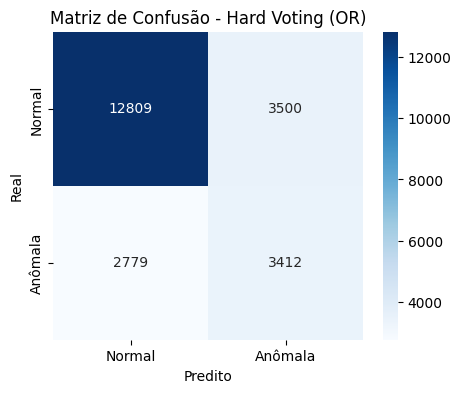


=== [Ensemble: Soft Voting (pesos)] ===
(Classe 1 - Anômala) Precision=0.7447, Recall=0.5413, F1=0.6269
              precision    recall  f1-score   support

  Normal (0)     0.8422    0.9295    0.8837     16309
 Anômala (1)     0.7447    0.5413    0.6269      6191

    accuracy                         0.8227     22500
   macro avg     0.7934    0.7354    0.7553     22500
weighted avg     0.8154    0.8227    0.8131     22500



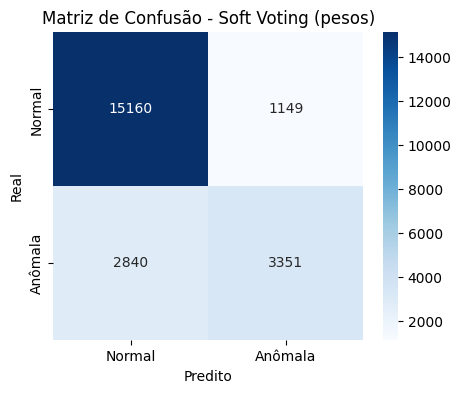


=== [Ensemble: Condorcet (Mediana)] ===
(Classe 1 - Anômala) Precision=0.5871, Recall=0.4267, F1=0.4942
              precision    recall  f1-score   support

  Normal (0)     0.8028    0.8861    0.8424     16309
 Anômala (1)     0.5871    0.4267    0.4942      6191

    accuracy                         0.7597     22500
   macro avg     0.6950    0.6564    0.6683     22500
weighted avg     0.7435    0.7597    0.7466     22500



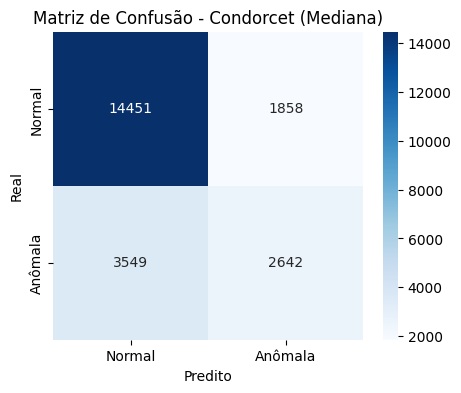


=== [Ensemble: Voting Ponderado Precision] ===
(Classe 1 - Anômala) Precision=0.4908, Recall=0.5405, F1=0.5145
              precision    recall  f1-score   support

  Normal (0)     0.8186    0.7872    0.8026     16309
 Anômala (1)     0.4908    0.5405    0.5145      6191

    accuracy                         0.7193     22500
   macro avg     0.6547    0.6638    0.6585     22500
weighted avg     0.7284    0.7193    0.7233     22500



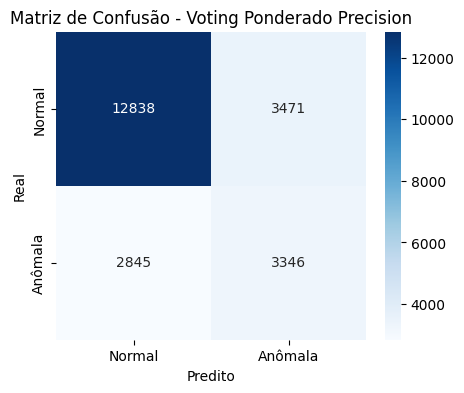


=== [Ensemble: Borda (Recall)] ===
(Classe 1 - Anômala) Precision=0.2190, Recall=0.4689, F1=0.2985
              precision    recall  f1-score   support

  Normal (0)     0.6442    0.3651    0.4660     16309
 Anômala (1)     0.2190    0.4689    0.2985      6191

    accuracy                         0.3936     22500
   macro avg     0.4316    0.4170    0.3823     22500
weighted avg     0.5272    0.3936    0.4200     22500



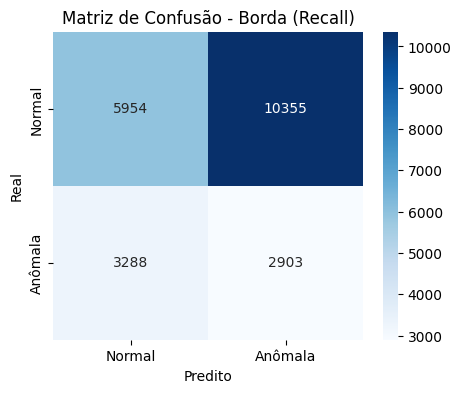


=== [Ensemble: Dempster-Shafer] ===
(Classe 1 - Anômala) Precision=0.4936, Recall=0.5511, F1=0.5208
              precision    recall  f1-score   support

  Normal (0)     0.8217    0.7854    0.8031     16309
 Anômala (1)     0.4936    0.5511    0.5208      6191

    accuracy                         0.7209     22500
   macro avg     0.6577    0.6683    0.6620     22500
weighted avg     0.7314    0.7209    0.7255     22500



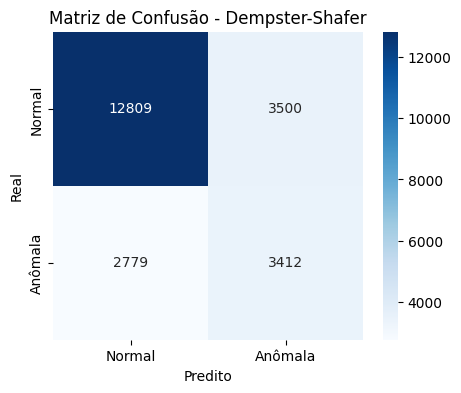


✅ Ensemble Avançado finalizado com sucesso!


In [ ]:
# Thresholds AEs
th_vae      = 0.437021
th_ae_lstm  = 0.546231
th_ae_gru   = 0.591295

# Chamada ao ensemble avançado completo
results_final = ensemble_comparison_advanced(
    score_vae,
    score_ae_lstm,
    score_ae_gru,
    iso_scores_val,
    zscore_val,
    th_vae,
    th_ae_lstm,
    th_ae_gru,
    y_val_recon,
    hard_voting_criteria="OR",
    weights_soft=[1.2, 0.8, 1.5, 1.1, 1.0],
    dynamic_threshold=True
)

print("\n✅ Ensemble Avançado finalizado com sucesso!")


# Condorcet corrigido

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def schulze_method(pairwise_matrix):
    """
    Implementação do método de Schulze para selecionar o melhor modelo baseado em força dos caminhos.

    pairwise_matrix: Matriz (MxM) onde cada posição (i,j) indica quantas vezes i venceu j.
    Retorna o índice do modelo vencedor.
    """
    n = pairwise_matrix.shape[0]
    strength = np.copy(pairwise_matrix)

    for i in range(n):
        for j in range(n):
            if i != j:
                for k in range(n):
                    if i != k and j != k:
                        strength[j, k] = max(strength[j, k], min(strength[j, i], strength[i, k]))

    winners = np.zeros(n, dtype=int)
    for i in range(n):
        for j in range(n):
            if i != j and strength[i, j] > strength[j, i]:
                winners[i] += 1

    return np.argmax(winners)

def condorcet_ensemble_classifier(df_bin):
    """
    Implementação do Condorcet Ensemble Classifier conforme descrito.

    df_bin: DataFrame (N, M) - cada coluna representa um modelo binário (0/1)
    Retorna um array com as previsões finais do ensemble.
    """
    n_samples, n_models = df_bin.shape
    votes = np.zeros((n_samples, 2))  # Votos acumulados para as classes [0, 1]

    for i in range(n_models):
        for j in range(i + 1, n_models):
            mask_agreement = (df_bin.iloc[:, i] == df_bin.iloc[:, j])  # Ambos concordam
            mask_disagreement = ~mask_agreement  # Discordam

            # Se ambos concordam sobre o mesmo label, dão 3 votos a esse label (favorecendo recall)
            votes[mask_agreement, df_bin.iloc[:, i][mask_agreement]] += 3

            # Se discordam, cada um dá 1 voto ao seu próprio label (para ser mais permissivo)
            votes[mask_disagreement, df_bin.iloc[:, i][mask_disagreement]] += 1
            votes[mask_disagreement, df_bin.iloc[:, j][mask_disagreement]] += 1

    # Determinar o label vencedor (argmax dos votos)
    final_preds = np.argmax(votes, axis=1)

    return final_preds

def ensemble_condorcet_schulze(
    score_vae, score_ae_lstm, score_ae_gru,
    score_isof, score_zscore,
    th_vae, th_ae_lstm, th_ae_gru,
    y_val
):
    """
    Implementação de 3 versões do Ensemble:
    - Condorcet
    - Schulze
    - Condorcet + Schulze (fallback)
    """
    # Binariza os modelos
    bin_vae   = (score_vae      > th_vae).astype(int)
    bin_lstm  = (score_ae_lstm  > th_ae_lstm).astype(int)
    bin_gru   = (score_ae_gru   > th_ae_gru).astype(int)
    th_isof   = np.quantile(score_isof, 0.85)  # Ajuste para favorecer recall
    th_zscore = np.quantile(score_zscore, 0.85)
    bin_isof  = (score_isof   > th_isof).astype(int)
    bin_zscore= (score_zscore > th_zscore).astype(int)

    # DataFrame das previsões binárias
    df_bin = pd.DataFrame({
        "VAE": bin_vae,
        "AE_LSTM": bin_lstm,
        "AE_GRU": bin_gru,
        "IsoForest": bin_isof,
        "Zscore": bin_zscore
    })

    ############################################################################
    # (1) Condorcet - Método de Comparações entre Modelos
    ############################################################################
    arr_scores = df_scores_norm.values
    n_samples, n_models = arr_scores.shape

    condorcet_preds = []
    for k in range(n_samples):
        sum_duelos = 0
        row = arr_scores[k]
        for i in range(n_models):
            for j in range(i+1, n_models):
                if row[i] > row[j]:
                    sum_duelos += 1.5  # Ajustado para menos viés
                elif row[i] < row[j]:
                    sum_duelos -= 0.7  # Penalidade menor do que antes

        # Aplicação de um critério de votos para suavizar
        vote_ratio = (sum_duelos + (n_models * (n_models - 1) / 2)) / (n_models * (n_models - 1))
        condorcet_preds.append(1 if vote_ratio >= 0.55 else 0)

    results["Condorcet (Suavizado)"] = np.array(condorcet_preds)
    ############################################################################
    # (2) Schulze - Método de Força de Caminhos
    ############################################################################
    arr_bin = df_bin.values
    n_models = arr_bin.shape[1]
    pairwise_matrix = np.zeros((n_models, n_models))

    for i in range(n_models):
        for j in range(n_models):
            if i != j:
                pairwise_matrix[i, j] = np.sum(arr_bin[:, i] > arr_bin[:, j])

    schulze_winner = schulze_method(pairwise_matrix)
    schulze_preds = df_bin.iloc[:, schulze_winner].values  # Predições do vencedor

    ############################################################################
    # (3) Condorcet + Schulze (Fallback se Condorcet falhar)
    ############################################################################
    hybrid_preds = condorcet_preds.copy()

    # Se Condorcet for indeciso (exemplo: gera tudo 0 ou 1), aplicamos Schulze
    if np.mean(hybrid_preds) < 0.01 or np.mean(hybrid_preds) > 0.99:
        print("⚠️ Condorcet muito enviesado, aplicando Schulze como fallback.")
        hybrid_preds = schulze_preds

    ############################################################################
    # Avaliação dos 3 Métodos
    ############################################################################
    resultados = {
        "Condorcet": condorcet_preds,
        "Schulze": schulze_preds,
        "Condorcet + Schulze": hybrid_preds
    }

    for method_name, pred in resultados.items():
        print(f"\n=== [Ensemble: {method_name}] ===")
        prec, rec, f1, _ = precision_recall_fscore_support(y_val, pred, average='binary')
        print(f"(Classe 1 - Anômala) Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        print(classification_report(y_val, pred, digits=4, target_names=["Normal (0)", "Anômala (1)"]))

        # Matriz de confusão
        cm = confusion_matrix(y_val, pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                    xticklabels=["Normal", "Anômala"],
                    yticklabels=["Normal", "Anômala"])
        plt.title(f"Matriz de Confusão - {method_name}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()

    return resultados
